In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os

In [2]:
architectures = ["fcn", "in_fourier", "deeponet", "fno"]
methods = ["adam", "swim"]

results = []
for architecture in architectures:
    for method in methods:
        tag = f"{architecture}_{method}"
        tag_path = f"{tag}_mean.csv"
        if not os.path.exists(tag_path):
            print(f"Couldn't find results for {tag}.")
            continue 

        tag_df = pd.read_csv(tag_path, index_col=0)
        print(f"{tag}: {len(tag_df)} experiments loaded.")
        results.append(tag_df)

results = pd.concat(results)
results = results.reset_index()

fcn_adam: 60 experiments loaded.
fcn_swim: 45 experiments loaded.
in_fourier_adam: 180 experiments loaded.
in_fourier_swim: 135 experiments loaded.
deeponet_adam: 180 experiments loaded.
deeponet_swim: 135 experiments loaded.
fno_adam: 72 experiments loaded.
fno_swim: 270 experiments loaded.


In [3]:
grid_columns = ["architecture", "method", "n_layers", "n_modes", "layer_width"]
target_column = "val_rel_l2"
results = results.fillna("no")
minimized = results.loc[results.groupby(grid_columns)[target_column].idxmin()]

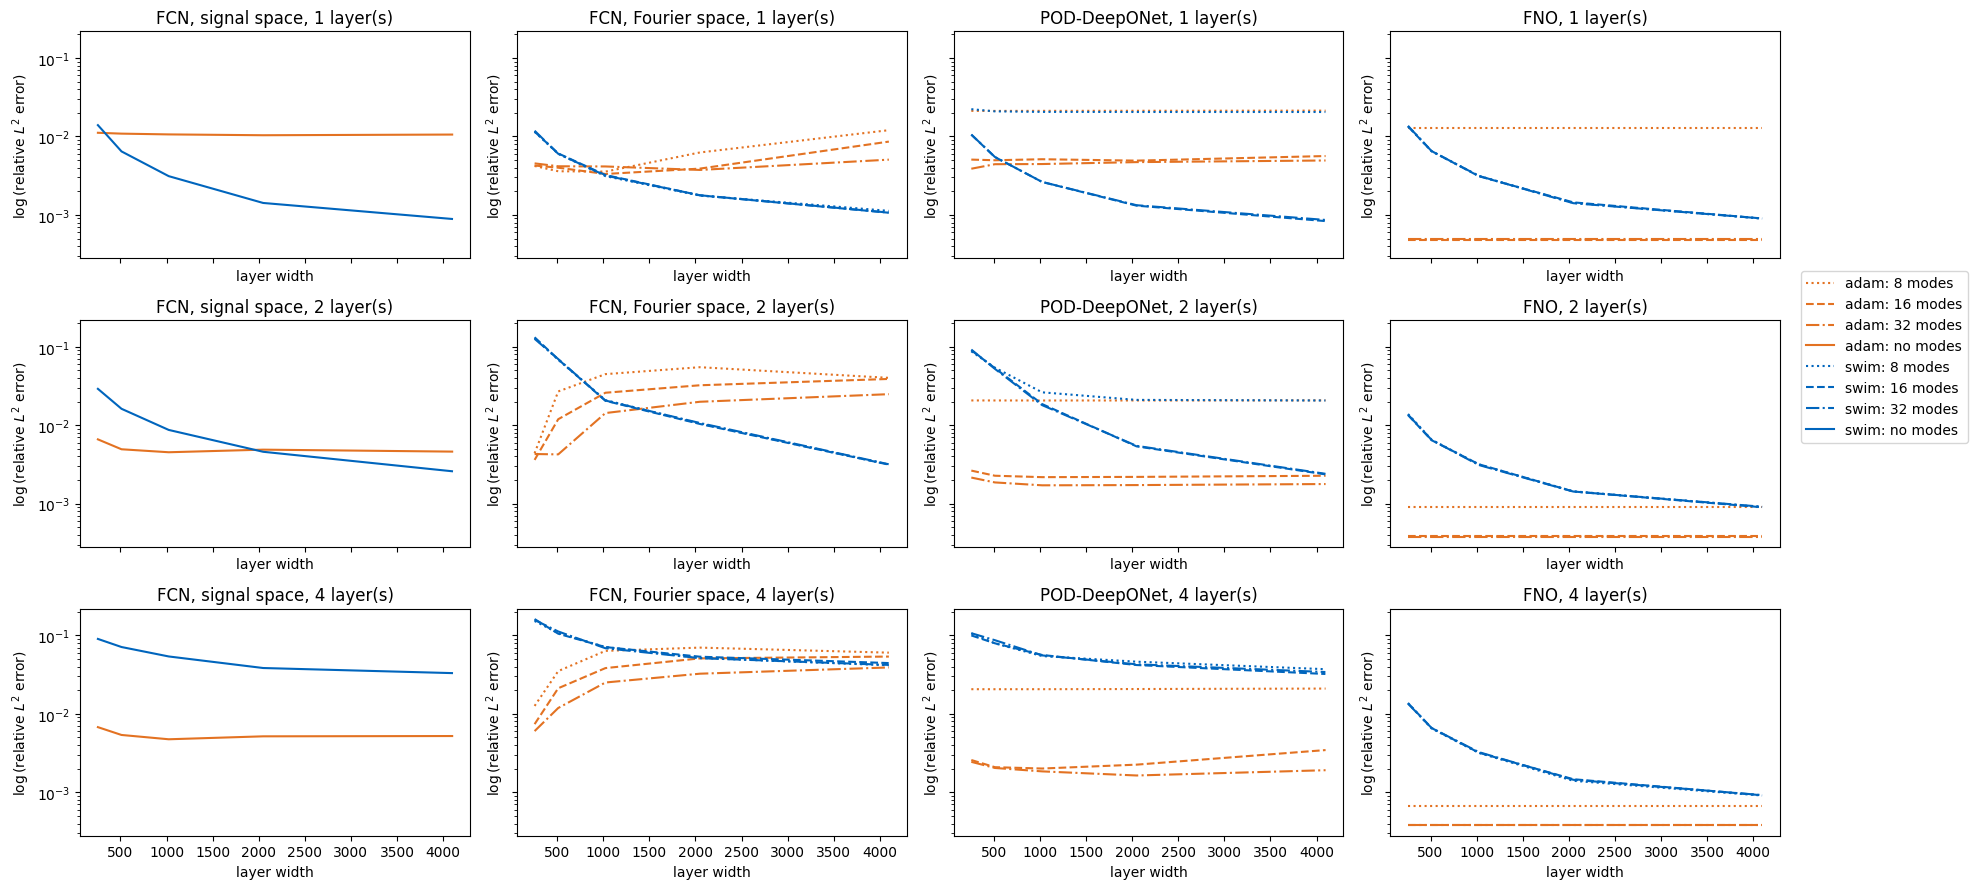

In [4]:
colors = {"adam": "#E37222", "swim": "#0065BD"}
modes_linestyles = {
    8: "dotted",
    16: "dashed",
    32: "dashdot",
    "no": "solid"
}

labels = {"fcn": "FCN, signal space", "in_fourier": "FCN, Fourier space", "deeponet": "POD-DeepONet", "fno": "FNO"}

layers = minimized["n_layers"].unique()
fig, axes = plt.subplots(len(layers), len(architectures),
                         sharex=True, sharey=True,
                         figsize=(4.5*len(architectures), 3*len(layers)))

fake_x = 0
fake_y = 0

for i, layer in enumerate(layers):
    for j, architecture in enumerate(architectures):

        model_label =  labels[architecture]
        axes[i][j].set_xlabel("layer width")
        axes[i][j].set_ylabel(r"$\log$(relative $L^2$ error)")
        axes[i][j].set_title(f"{model_label}, {layer} layer(s)")

        for method in methods:
            query = f"method=='{method}'"
            query += f" and architecture=='{architecture}'"
            query += f" and n_layers=={layer}"

            selected = minimized.query(query)
            for mode, values in selected.groupby("n_modes"):  
                target_values = values[target_column]
                if len(target_values) == 1:
                    # No dependency on the layer width (FNO; adam).
                    width_values = minimized.query(f"architecture=='{architecture}' and layer_width!='no'")["layer_width"]
                    min_width = width_values.min()
                    max_width = width_values.max()
                    axes[i][j].plot([min_width, max_width],
                                    [target_values.iloc[0], target_values.iloc[0]],
                                    c=colors[method],
                                    linestyle=modes_linestyles[mode])
                else:
                    width_values = values["layer_width"]
                    axes[i][j].plot(width_values, target_values,
                                    c=colors[method], linestyle=modes_linestyles[mode])

# For pretty legend later
fake_x = width_values.iloc[0]
fake_y = target_values.iloc[0]

for method in methods:
    for mode, style in modes_linestyles.items():
        label = f"{method}: {mode} modes"
        axes[0][0].plot([fake_x], [fake_y], c=colors[method], linestyle=style, label=label)
fig.legend(bbox_to_anchor=(1.1, 0.7));
plt.yscale("log")
fig.tight_layout()